In [1]:
import copy, os, gc, tqdm
import numpy as np
import pickle as pkl
from time import time, sleep

from IPython import display
from collections import Counter
from itertools import product, chain, combinations

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
import sys
library_path = '../../'
if library_path not in sys.path:
    sys.path.append(library_path)

CIFAR10_DIR = library_path + 'datasets/CIFAR10'
MNIST_DIR = library_path + 'datasets/MNIST'

from ml.utils import get_CIFAR10_data, get_MNIST_data

In [50]:
#matplotlib
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
%matplotlib inline

#https://matplotlib.org/users/customizing.html
matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.01
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 20
# Configuring latex fonts
matplotlib.rc('font', **{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', unicode=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

<a id='toc'></a>
* [1. Modules](#modules)
    * [1.1 Base objects](#base)
        * [1.1.1 Layer](#layer)
        * [1.1.2 Sequential](#seq)
    * [1.2 Helpers](#helpers)
        * [1.2.1 Initializers](#initializers)
        * [1.2.2 Regularizers](#regularizers)
        * [1.2.3 Gradients checker](#grad_checker)
    * [1.3 Layers](#layers)
        * [1.3.1 Dense](#dense)
            * [1.3.1.1 Dense: forward](#dense_forward)
            * [1.3.1.2 Dense: backward](#dense_backward)
        * [1.3.2 Softmax](#softmax)
        * [1.3.3 Dropout](#dropout)
            * [1.3.3.1 Dropout: forward](#dropout_forward)
            * [1.3.3.2 Dropout: backward](#dropout_backward)
        * [1.3.4 BatchNormalization](#bn)
            * [1.3.4.1 BatchNormalization: forward](#bn_forward)
            * [1.3.4.2 BatchNormalization: backward](#bn_backward)
    * [1.4 Activations](#activations)
        * [1.4.1 Tanh](#tanh)
        * [1.4.2 ReLU](#relu)
        * [1.4.3 LeakyReLU](#leaky_relu)
        * [1.4.4 ELU](#elu)
        * [1.4.5 SoftPlus](#softplus)
    * [1.5 Criterions](#criterions)      
        * [1.5.1 MSE](#mse)
        * [1.5.2 MulticlassLogLoss](#logloss)
    * [1.6 Model](#model)
    * [1.7 Update rules](#optimizers)
        * [1.7.1](#update_sgd_momentum)
        * [1.7.2](#update_rmsprop)
        * [1.7.3](#update_adam)
    * [1.8 Solver](#solver)
* [2. Fully Connected Network](#fcn)
    * [2. Toy example](#toy_example)
        * [2.1 Network 1](#toy_example_net1)
        * [2.2 Network 2](#toy_example_net2)
    * [3. Digits classification](#digits)
        * [3.1 Test run](#digits_test)
        * [3.2 Comparison](#comparison)
        * [3.3 Final run](#digits_final)
    * [X.X Comparison of architectures](#comp_architectures)
    * [X.X Comparison of update rules](#comp_updates)
    * [X.X Dropout](#comp_dropout)
    * [X.X BatchNormalization](#comp_inits)
* [3. Convolutional Network](#cnn)

<a id='modules'></a>
# 1. Modules[[toc]](#toc)

<a id='base'></a>
## 1.1 Base objects [[toc]](#toc)

<a id='layer'></a>
### 1.1.1 Layer [[toc]](#toc)

In [100]:
# %load ../../ml/neural_network/sequential/layer.py

#import numpy as np
#from collections import OrderedDict

def dtype_conversion(fn):
    def fn_(self=None, *args, **kwargs):
        dtype = self.dtype
        return fn(self, 
                  *[arg.astype(dtype, copy=False) for arg in args], 
                  **{k: v.astype(dtype, copy=False) for k, v in kwargs.items()})
    return fn_

def check_initialized(fn):
    def fn_(self=None, *args, **kwargs):
        assert self.initialized, 'Object {} must be initialized to call its methods.'.format(self)
        return fn(self, *args, **kwargs)
    return fn_

def check_compiled(fn):
    def fn_(self=None, *args, **kwargs):
        assert self.compiled, 'Model {} must be compiled before usage.'.format(self)
        return fn(self, *args, **kwargs)
    return fn_

class Layer:
    # Checks
    def _assert_nans(self, arr):
        assert not np.any(np.isnan(arr)), 'NaNs etected: {}!'.format(self)
    def _assert_infs(self, arr):
        assert not np.any(np.isinf(arr)), 'Infs detected {}!'.format(self)
    def _check_arrays(self, *arrays):
        if not self.debug: return
        for arr in arrays:
            self._assert_nans(arr)
            self._assert_infs(arr)
    
    def __init__(self):
        self.output = None       # Output of the layer is always kept for backpropagatoin
        self.grad_input = None   # Input gradient is saved just in case
        self.training = True     # 
        
        self._forward_enter_callback  = lambda: None
        self._forward_exit_callback   = lambda: None
        self._backward_enter_callback = lambda: None
        self._backward_exit_callback  = lambda: None
        
        self.dtype = None         # Must be set during initialization
        self.debug = False        # Must be set during initialization
        self.initialized = False  # Must be set to True after initialization
        
    def __repr__(self):
        return type(self).__name__
    
    # Setting callbacks
    def set_forward_enter_call(self, callback=lambda: None):
        self._forward_enter_callback = callback
    def set_forward_exit_call(self, callback=lambda: None):
        self._forward_exit_callback = callback
    def set_backward_enter_call(self, callback=lambda: None):
        self._backward_enter_callback = callback
    def set_backward_exit_call(self, callback=lambda: None):
        self._backward_exit_callback = callback
    
    # Initialization
    def initialize(self, params):
        """This function is called during compilation process to initialize layer"""
        params = self._initialize(params)
        self.initialized = True
        return params
    def _initialize(self, params):
        """Must be called at each layer via super()._initialize(params) at the beginning of layer.initialize() call"""
        params = self._check_initialization_params(params)
        params = self._initialize_name(params)
        self.seed  = params['seed']
        self.debug = params['debug']
        self.dtype = params['dtype']
        self.grad_clip = params['grad_clip']
        return params
    def _check_initialization_params(self, params):
        assert 'input_shape' in params, 'Input shape must be provided.' # This is probably not critical
        params.setdefault('seed', 0)
        params.setdefault('names', {})
        params.setdefault('debug', False)
        params.setdefault('dtype', np.float64)
        params.setdefault('grad_clip', np.inf)
        return params
    def _initialize_name(self, params):
        names = params['names']
        layer_type_name = type(self).__name__
        n_layers = names.setdefault(layer_type_name, 0)
        self.name = layer_type_name + str(n_layers)
        names[layer_type_name] += 1
        return params

    # Forward propagation
    @check_initialized
    @dtype_conversion
    def forward(self, input):
        self._forward_enter_callback()
        self._check_arrays(input)        # Check
        self.update_output(input)        # Finding output tensor; self.output
        self._forward_exit_callback()    # Callback during forward propagation
        return self.output
    def update_output(self, input):
        self.output = input

    # Backward propagation
    @check_initialized
    @dtype_conversion
    def backward(self, input, grad_output):
        self._backward_enter_callback()
        self._check_arrays(input, grad_output)     # Checks and transformations
        self.update_grad_input(input, grad_output) # This updates self.grad_input
        self.update_grad_param(input, grad_output) # This updates all grad params
        self._clip_gradients()
        self._backward_exit_callback()
        return self.grad_input
    def update_grad_input(self, input, grad_output):
        assert input.shape == grad_output.shape
        self.grad_input = grad_output

    def update_grad_param(self, input, grad_output):
        pass
    def _clip_gradients(self):
        np.clip(self.grad_input, -self.grad_clip, self.grad_clip, self.grad_input)
        grad_params = self.get_grad_params()
        for param_name, param_value in grad_params.items():
            np.clip(param_value,-self.grad_clip, self.grad_clip, param_value)
    
    # Regulariation
    @check_initialized
    def get_regularization_loss(self):
        return 0.0
    
    # Getting params and gradients
    @check_initialized
    def get_params(self):
        return OrderedDict()
    @check_initialized
    def get_grad_params(self):
        return OrderedDict()
    @check_initialized
    def zero_grad_params(self):
        pass
    @check_initialized
    def set_params(self, new_params):
        params = self.get_params()
        for param_name in new_params:
            np.copyto(params[param_name], new_params[param_name]) 

    # Changing network mode
    @check_initialized
    def train(self):
        self.training = True
    @check_initialized
    def evaluate(self):
        self.training = False

<a id='seq'></a>
### 1.1.2 Sequential [[toc]](#toc)

In [101]:
# %load ../../ml/neural_network/sequential/sequential.py

import numpy as np
import copy
from collections import OrderedDict
#from .layer import Layer

class Sequential(Layer):
    def __init__(self, layers=[]):
        super().__init__()
        self.layers = []
        for layer in layers:
            self.add(layer)
    def add(self, layer):
        assert isinstance(layer, Layer)
        self.layers.append(layer)
    def __repr__(self):
        return '->'.join([str(layer) for layer in self.layers])
 
    # Initialization
    def _initialize(self, params):
        params = super()._initialize(params)
        for layer in self.layers:
            params = layer.initialize(params)
        return params

    # Forward propagation
    def update_output(self, input):
        """This function passes input through all layers and saves output"""
        for layer in self.layers:
            output = layer.forward(input)
            input = output
        self.output = output
        return self.output
        
    # Backward propagation
    def backward(self, input, grad_output):
        """This function backpropagates though all layers"""
        n_layers = len(self.layers)
        for n_layer in reversed(list(range(1, n_layers))):
            grad_output = self.layers[n_layer].backward(self.layers[n_layer - 1].output, grad_output)
        self.grad_input = self.layers[0].backward(input, grad_output)
        return self.grad_input
        
    # Get params and their gradients
    @check_initialized
    def get_params(self):
        params = OrderedDict()
        for layer in self.layers:
            for param_name, param_value in layer.get_params().items():
                params[param_name] = param_value
        return params
    @check_initialized
    def get_grad_params(self):
        grad_params = OrderedDict()
        for layer in self.layers:
            for grad_name, grad_value in layer.get_grad_params().items():
                grad_params[grad_name] = grad_value
        return grad_params
    
    @check_initialized
    def zero_grad_params(self):
        for layer in self.layers:
            layer.zero_grad_params()
            
    # Regularization
    @check_initialized
    def get_regularization_loss(self):
        loss = 0.0
        for layer in self.layers:
            loss += layer.get_regularization_loss()
        return loss

    @check_initialized
    def train(self):
        """Sets all layers to training mode"""
        for layer in self.layers:
            layer.train()
    @check_initialized
    def evaluate(self):
        """Sets all layers to evaluation mode"""
        for layer in self.layers:
            layer.evaluate()

<a id='helpers'></a>
## 1.2 Helper objects [[toc]](#toc)

<a id='initializers'></a>
### 1.2.1 Initializers [[toc]](#toc)

In [102]:
# %load ../../ml/neural_network/initializers/initializers.py

import numpy as np


class Initializer:
    def __init__(self):
        pass

    
class DeterministicInitializer(Initializer):
    def __init__(self, init_value):
        self.init_value = init_value
    def __call__(self, shape=None, dtype=np.float32):
        return self.init_value.astype(dtype)


class RandomInitializer(Initializer):
    def __init__(self, seed=None):
        super().__init__()
        self.gen = np.random.RandomState(seed)

        
class ZerosInitializer(Initializer):
    def __init__(self):
        super().__init__()
    def __call__(self, shape=None, dtype=np.float32):
        if shape is None:
            return 0.0
        return np.zeros(shape, dtype=dtype)


class NormalInitializer(RandomInitializer):
    def __init__(self, seed=None):
        super().__init__(seed=seed)
    def __call__(self, shape=None, dtype=np.float32):
        stddev = 1.0
        if len(shape) == 2:
            stddev = 1. / np.sqrt(shape[0])
        if len(shape) == 4:
            stddev = 1.0 / np.sqrt(np.prod(shape[1:]))
        return self.gen.uniform(-stddev, stddev, size=shape).astype(dtype)


class NormalInitializer(RandomInitializer):
    def __init__(self, seed=None):
        super().__init__(seed=seed)
        
    def __call__(self, shape=None, dtype=np.float32):
        stddev = 1.0
        if len(shape) == 2:
            stddev = 1. / np.sqrt(shape[0])
        if len(shape) == 4:
            stddev = 1.0 / np.sqrt(np.prod(shape[1:]))
        return self.gen.normal(loc=0, scale=stddev, size=shape).astype(dtype)

<a id='regularizers'></a>
### 1.2.2 Regularizers [[toc]](#toc)

In [103]:
# %load ../../ml/neural_network/regularizers/regularizers.py

import numpy as np


class Regularizer:
    pass


class EmptyRegularizer(Regularizer):
    def __bool__(self):
        return False


class L2regularizer(Regularizer):
    def __init__(self, l2=0.0):
        self.l2 = l2
    def __bool__(self):
        return True
    def loss(self, arr):
        return 0.5 * self.l2 * np.sum(arr ** 2)
    def grad(self, arr):
        return self.l2 * arr

<a id='grad_checker'></a>
### 1.2.3 Gradients Checker [[toc]](#toc)

In [10]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval
        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad


class GradientsChecker:
    def __init__(self, step=1e-5):
        self.step = step
        
    def eval_gradients(self, layer, input, grad_output):
        assert isinstance(input, np.ndarray) # It must be an array
        self.layer = layer
        self.input = input
        self.num_grad_input = eval_numerical_gradient_array(self.forward, input, grad_output, self.step)
        self.num_grad_params = OrderedDict()
        for param_name, param_value in layer.get_params().items():
            self.num_grad_params[param_name] = eval_numerical_gradient_array(
                self.forward, param_value, grad_output, self.step)
        self.grad_input  = layer.backward(input, grad_output)
        self.grad_params = layer.get_grad_params()
        
    def __call__(self, layer, input, grad_output):
        self.eval_gradients(layer, input, grad_output)
        for param_name in layer.get_params():
            print('grad_{} error: {}'.format(param_name, 
                  rel_error(self.num_grad_params[param_name], self.grad_params[param_name])))
        print('grad_X error: {}'.format(rel_error(self.num_grad_input, self.grad_input)))
        
    def forward(self, *args, **kwargs):
        return self.layer.forward(self.input)

<a id='layers'></a>
## 1.3 Layers [[toc]](#toc)

<a id='dense'></a>
### 1.3.1 Dense [[toc]](#toc)

In [104]:
# %load ../../ml/neural_network/layers/dense.py

#import numpy as np
from collections import OrderedDict


class Dense(Layer):
    def __init__(self, units, use_bias=True, W_init=None, b_init=None, W_reg=None, b_reg=None):
        """
        Inputs:
        - units - Integer or Long, dimensionality of the output space.
        - W_initializer
        - b_initializer
        - seed - used for initializers!!!
        """
        super().__init__()
        self.units = units
        self.use_bias = use_bias
        self.W_init = W_init
        self.b_init = b_init
        self.W_reg = W_reg
        self.b_reg = b_reg
        
    def __repr__(self):
        if hasattr(self, 'W'):
            input_size, output_size = self.W.shape
        else:
            input_size = '?'
            output_size = self.units
        return 'Dense({}->{})'.format(input_size, output_size)   
    
    # Initialization
    def _initialize(self, params):
        # Params check and name initialization
        params = super()._initialize(params)
        # Initializing params and grads
        params = self._initialize_W(params)
        params = self._initialize_b(params)
        # Regularization
        if self.W_reg is None: self.W_reg = EmptyRegularizer()
        if self.b_reg is None: self.b_reg = EmptyRegularizer()
        return params
    
    def _initialize_W(self, params):
        input_shape, seed, dtype = params['input_shape'], params['seed'], params['dtype']
        if self.W_init is None:
            self.W_init= NormalInitializer(seed=seed)
        elif isinstance(self.W_init, np.ndarray):
            assert self.W_init.shape == (input_shape[1], self.units)
            self.W_init = DeterministicInitializer(self.W_init)
        self.W = self.W_init(shape=(input_shape[1], self.units), dtype=dtype)
        self.grad_W = np.zeros_like(self.W, dtype=dtype)
        params['seed'] = seed + 1
        params['input_shape'] = (input_shape[0], self.units) # Input shape for the next layer
        return params
        
    def _initialize_b(self, params):
        dtype = params['dtype']
        if self.b_init is None:
            self.b_init = ZerosInitializer()
        elif isinstance(self.b_init, np.ndarray):
            assert self.b_init.shape == (self.units,)
            self.b_init = DeterministicInitializer(self.b_init)
        self.b = self.b_init(shape=(self.units,), dtype=dtype)
        self.grad_b = np.zeros_like(self.b, dtype=dtype)
        return params
    
    # Forward propagation
    def update_output(self, input):
        self.output = np.dot(input, self.W)  # [B x I] x [I x O] = [B x O]
        if self.use_bias:
            self.output += self.b[None, :]
        return self.output
    
    # Backward propagation
    def update_grad_input(self, input, grad_output):
        self.grad_input = np.dot(grad_output, self.W.T)         # [N x H] x [H x D] = [N x D]
        return self.grad_input
    def update_grad_param(self, input, grad_output):
        self.grad_W = np.dot(input.T, grad_output)               # ([D x N] x [N x H]).T = [D, H]
        if self.W_reg: self.grad_W += self.W_reg.grad(self.W)
        if self.use_bias:
            self.grad_b = np.sum(grad_output, axis=0)
            if self.b_reg: self.grad_b += self.b_reg.grad(self.b)
        
        
    @check_initialized
    def get_regularization_loss(self):
        loss = 0.0
        if self.W_reg: loss += self.W_reg.loss(self.W)
        if self.use_bias:
            if self.b_reg: loss += self.b_reg.loss(self.b)  
        return loss
    
    @check_initialized
    def get_params(self):
        return OrderedDict([(self.name + ':W', self.W), (self.name + ':b', self.b)])
    @check_initialized
    def get_grad_params(self):
        return OrderedDict([(self.name + ':W', self.grad_W), (self.name + ':b', self.grad_b)])
    @check_initialized
    def zero_grad_params(self):
        self.grad_W.fill(0)
        self.grad_b.fill(0)

In [12]:
dense = Dense(units=100)
print(dense)
print(dense.initialize({'input_shape': (10, 20)}))
print(dense)

Dense(?->100)
{'seed': 1, 'grad_clip': inf, 'debug': False, 'input_shape': (10, 100), 'dtype': <class 'numpy.float64'>, 'names': {'Dense': 1}}
Dense(20->100)


<a id='dense_forward'></a>
#### 1.3.1.1 Dense: forward [[toc]](#toc)

In [13]:
# Test the affine_forward function
batch_size = 2
input_size = 120
output_size = 3

dtype = np.float64
X = np.linspace(-0.1, 0.5, num=batch_size * input_size).reshape(batch_size, input_size) # [2, 120]
W = np.linspace(-0.2, 0.3, num=input_size * output_size).reshape(input_size, output_size) # [360] - > [120, 3]
b = np.linspace(-0.3, 0.1, num=output_size)
X = X.astype(dtype)
W = W.astype(dtype)
b = b.astype(dtype)
dense = Dense(output_size, W_init=W, b_init=b)
dense.initialize({'input_shape': (-1, 120)})

output = dense.forward(X)
correct_output = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                           [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(output, correct_output))

Testing affine_forward function:
difference:  9.7698488884e-10


<a id='dense_backward'></a>
#### 1.3.1.2 Dense: backward [[toc]](#toc)

In [14]:
# Test the affine_backward function
np.random.seed(231)
dtype = np.float64
X = np.random.randn(10, 6).astype(dtype)
W = np.random.randn(6, 5).astype(dtype)
b = np.random.randn(5).astype(dtype)
grad_Y = np.random.randn(10, 5).astype(dtype)
print('X.shape =', X.shape)
print('W.shape =', W.shape)
print('b.shape =', b.shape)

dense = Dense(5, W_init=W, b_init=b)
dense.initialize({'input_shape': X.shape})
grad_checker = GradientsChecker()
grad_checker(dense, X, grad_Y)

X.shape = (10, 6)
W.shape = (6, 5)
b.shape = (5,)
grad_Dense0:W error: 2.1752635504596857e-10
grad_Dense0:b error: 7.736978834487815e-12
grad_X error: 1.0908199508708189e-10


<a id='softmax'></a>
### 1.3.2 Softmax [[toc]](#toc)

In [105]:
# %load ../../ml/neural_network/layers/softmax.py

import numpy as np
#from ..sequential import Layer

class SoftMax(Layer):
    def __init__(self):
        super().__init__()
    
    def update_output(self, input):
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        np.exp(self.output, self.output)
        self.output /= np.sum(self.output, axis=1, keepdims=True)
        return self.output
    
    def update_grad_input(self, input, grad_output):
        G = np.multiply(self.output, grad_output)
        self.grad_input = G - self.output * np.sum(G, axis=1, keepdims=True)
        return self.grad_input

In [102]:
softmax = SoftMax()
print(softmax.initialize({'input_shape': (10, 25)}))

{'seed': 0, 'input_shape': (10, 25), 'names': {'SoftMax': 1}, 'debug': False, 'dtype': <class 'numpy.float64'>}


<a id='dropout'></a>
### 1.3.3 Dropout [[toc]](#toc)
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

In [106]:
# %load ../../ml/neural_network/layers/dropout.py

#import numpy as np
#from ..sequential import Layer


class Dropout(Layer):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p
        self.mask = None
    def __repr__(self):
        return super().__repr__() + '({})'.format(self.p)
        
    # initialization
    def _initialize(self, params):
        # Check params and initialize name
        params = super()._initialize(params)
        seed = params['seed']
        self.gen = np.random.RandomState(seed)
        params['seed'] += 1
        return params
    
    # Setters
    def set_p(self, p):
        self.p = p
    
    # Forward propagation
    def update_output(self, input):
        if self.training:
            self.mask = self.gen.choice([0, 1], p=[self.p, 1 - self.p], size=input.shape)
            self.output = np.multiply(self.mask, input)
        else:
            self.output = (1 - self.p) * input
        return self.output
    
    # Backward propagation
    def update_grad_input(self, input, grad_output):
        if self.training:
            self.grad_input = np.multiply(self.mask, grad_output)
        else:
            self.grad_input = (1 - self.p) * grad_output
        return self.grad_input

In [15]:
dropout = Dropout(0.5)
print(dropout.initialize({'input_shape': (10, 25)}))
print(dropout)

{'names': {'Dropout': 1}, 'debug': False, 'grad_clip': inf, 'seed': 1, 'dtype': <class 'numpy.float64'>, 'input_shape': (10, 25)}
Dropout(0.5)


<a id='dropout_forward'></a>
#### Dropout: forward [[toc]](#toc)

In [17]:
np.random.seed(231)
X = np.random.randn(500, 500) + 10
dropout = Dropout(0)
dropout.initialize({'input_shape': (10, 25)})

for p in [0.3, 0.6, 0.75]:
    dropout.p = p
    dropout.train()
    out      = dropout.forward(X)
    dropout.evaluate()
    out_test = dropout.forward(X)
    
    print('Running tests with p = ', p)
    print('Mean of input: ', X.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    print()

Running tests with p =  0.3
Mean of input:  10.0002078785
Mean of train-time output:  7.00311276126
Mean of test-time output:  7.00014551493
Fraction of train-time output set to zero:  0.299804
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.6
Mean of input:  10.0002078785
Mean of train-time output:  3.98521948532
Mean of test-time output:  4.00008315139
Fraction of train-time output set to zero:  0.60156
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.75
Mean of input:  10.0002078785
Mean of train-time output:  2.52026295957
Mean of test-time output:  2.50005196962
Fraction of train-time output set to zero:  0.748108
Fraction of test-time output set to zero:  0.0



<a id='dropout_backward'></a>
#### Dropout: backward [[toc]](#toc)

In [18]:
np.random.seed(231)
X = np.random.randn(5, 5) + 10
grad_Y = np.random.randn(*X.shape)

dropout = Dropout(0.8)
# The code below resets state of the dropout layer after each forward propagation
forward_callback = lambda: dropout.initialize({'input_shape': (10, 25)})
dropout.set_forward_exit_call(forward_callback)
forward_callback()

grad_checker = GradientsChecker()
grad_checker.eval_gradients(dropout, X, grad_Y)
grad_X     = grad_checker.grad_input
num_grad_X = grad_checker.num_grad_input

print('grad_X relative error: ', rel_error(grad_X, num_grad_X))

grad_X relative error:  1.89289321191e-11


<a id='bn'></a>
### 1.3.4 BatchNormalization [[toc]](#toc)
One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. One idea along these lines is batch normalization which was recently proposed by [3].

The idea is relatively straightforward. Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features; this will ensure that the first layer of the network sees data that follows a nice distribution. However even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

The authors of [3] hypothesize that the shifting distribution of features inside deep neural networks may make training deep networks more difficult. To overcome this problem, [3] proposes to insert batch normalization layers into the network. At training time, a batch normalization layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. To this end, the batch normalization layer includes learnable shift and scale parameters for each feature dimension.

[3] Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.

In [107]:
# %load ../../ml/neural_network/layers/batch_normalization.py
#import numpy as np
#from collections import OrderedDict
#from ..sequential import Layer

class BatchNormalization(Layer):
    """
    Forward pass for batch normalization.

    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the
    mean and variance of each feature, and these averages are used to normalize
    data at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var  = momentum * running_var  + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7
    implementation of batch normalization also uses running averages.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    def __init__(self, momentum=0.9, eps=1e-5):
        super().__init__()
        self.momentum = momentum
        self.eps = eps
        
    def _initialize(self, params):
        # Check params and initialize name
        params = super()._initialize(params)
        input_shape = params['input_shape']
        dtype = params['dtype']
        n_features = input_shape[1]
        self.running_mean = np.zeros(n_features, dtype=dtype)
        self.running_var = np.zeros(n_features, dtype=dtype)
        self.gamma = np.ones(n_features, dtype=dtype)
        self.beta = np.zeros(n_features, dtype=dtype)
        return params

    # Forward propagation
    def update_output(self, input):
        if self.training:
            self.sample_mean = np.mean(input, axis=0)
            self.sample_var = np.var(input, axis=0)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.sample_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.sample_var
            self.normed_input = (input - self.sample_mean[None, :]) / np.sqrt(self.sample_var + self.eps)[None, :]
            self.output = self.gamma[None, :] * self.normed_input + self.beta[None, :]
        else:
            normed_input = (input - self.running_mean[None, :]) / (np.sqrt(self.running_var[None, :] + self.eps))
            self.output = self.gamma[None, :] * normed_input + self.beta[None, :]
        return self.output

    # Backward propagation
    def update_grad_input(self, input, grad_output):
        if self.training:
            var = self.sample_var
        else:
            var = self.running_var
        self.grad_input = self.gamma / np.sqrt(var + self.eps)[None, :] *\
                ((grad_output - np.mean(grad_output, axis=0)[None, :]) -\
                 self.normed_input * np.mean(np.multiply(self.normed_input, grad_output), axis=0)[None, :]) 
    def update_grad_param(self, input, grad_output):
        self.grad_gamma = np.sum(np.multiply(self.normed_input, grad_output), axis=0)
        self.grad_beta = np.sum(grad_output, axis=0)
          
    # Get params and grad_params
    def get_params(self):
        return OrderedDict([(self.name + '/gamma', self.gamma), (self.name + '/beta', self.beta)])
    def get_grad_params(self):
        return OrderedDict([(self.name + '/gamma', self.grad_gamma), (self.name + '/beta', self.grad_beta)])

In [19]:
bn = BatchNormalization()
bn.initialize({'input_shape': (10, 25)})

{'debug': False,
 'dtype': numpy.float64,
 'grad_clip': inf,
 'input_shape': (10, 25),
 'names': {'BatchNormalization': 1},
 'seed': 0}

<a id='bn_forward'></a>
#### 1.3.4.1 Batch Normalization: forward [[toc]](#toc)

In [20]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

bn = BatchNormalization()
print(bn.initialize({'input_shape': a.shape}))

print('Before batch normalization:')
print('  means: ', a.mean(axis=0))
print('  stds: ', a.std(axis=0))

# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm = bn.forward(a)
print('  mean: ', a_norm.mean(axis=0))
print('  std: ', a_norm.std(axis=0))

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
bn.gamma = gamma
bn.beta = beta
a_norm  = bn.forward(a)
print('After batch normalization (nontrivial gamma, beta)')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

{'seed': 0, 'grad_clip': inf, 'debug': False, 'input_shape': (200, 3), 'dtype': <class 'numpy.float64'>, 'names': {'BatchNormalization': 1}}
Before batch normalization:
  means:  [ -2.3814598  -13.18038246   1.91780462]
  stds:  [ 27.18502186  34.21455511  37.68611762]
After batch normalization (gamma=1, beta=0)
  mean:  [  1.77635684e-17  -5.32907052e-17   2.13717932e-17]
  std:  [ 0.99999999  1.          1.        ]
After batch normalization (nontrivial gamma, beta)
  means:  [ 11.  12.  13.]
  stds:  [ 0.99999999  1.99999999  2.99999999]


In [21]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn = BatchNormalization()
bn.initialize({'input_shape': a.shape})
bn.gamma = np.ones(D3)
bn.beta = np.zeros(D3)
bn.train()

for t in range(50):
    X = np.random.randn(N, D1)
    a = np.maximum(0, X.dot(W1)).dot(W2)
    a_norm = bn.forward(a)

bn.evaluate()
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm = bn.forward(a)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

After batch normalization (test-time):
  means:  [-0.03927354 -0.04349152 -0.10452688]
  stds:  [ 1.01531428  1.01238373  0.97819988]


<a id='bn_backward'></a>
#### 1.3.4.2 Batch Normalization: backward  [[toc](#toc)]

In [22]:
# Gradient check batchnorm backward pass
np.random.seed(231)
N, D = 100, 5
X      = 5 * np.random.randn(N, D) + 12
gamma  = np.random.randn(D)
beta   = np.random.randn(D)
grad_Y = np.random.randn(N, D)
step   = 1e-5

grad_checker = GradientsChecker(step=step)
bn = BatchNormalization()
bn.initialize({'input_shape': X.shape})
bn.train()

grad_checker(bn, X, grad_Y)

grad_BatchNormalization0/gamma error: 3.4897447838672933e-11
grad_BatchNormalization0/beta error: 8.743146873306484e-11
grad_X error: 4.6504237753155334e-07


<a id='activations'></a>
## 1.4 Activations [[toc]](#toc)

<a id='tanh'></a>
### 1.4.1 Tanh [[toc]](#toc)

In [108]:
class Tanh(Layer):
    def __init__(self):
         super().__init__()
    
    def update_output(self, input):
        self.output = np.tanh(input)
        return self.output
    
    def update_grad_input(self, input, grad_output):
        self.grad_input = np.multiply((1 - self.output ** 2), grad_output)
        return self.grad_input

<a id='relu'></a>
### 1.4.2 ReLU [[toc]](#toc)
Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**): 

In [109]:
class ReLU(Layer):
    def __init__(self):
         super().__init__()
    
    def update_output(self, input):
        self.output = np.maximum(input, 0)
        return self.output
    
    def update_grad_input(self, input, grad_output):
        self.grad_input = np.multiply(grad_output, (input > 0).astype(self.dtype))
        return self.grad_input

<a id='leaky_relu'></a>
### 1.4.3 LeakyReLU [[toc]](#toc)
Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope. 

In [110]:
class LeakyReLU(Layer):
    def __init__(self, slope=0.03):
        super().__init__()
        self.slope = slope
        
    def update_output(self, input):
        self.output = np.array(input)
        self.output[self.output < 0] *= self.slope
        return self.output
    
    def update_grad_input(self, input, grad_output):
        self.grad_input = np.array(grad_output)
        self.grad_input[input < 0] *= self.slope
        return self.grad_input

<a id='elu'></a>
### 1.4.4 ELU [[toc]](#toc)
Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.

In [111]:
class ELU(Layer):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = alpha
        
    def update_output(self, input):
        self.output = np.array(input)
        self.mask = self.output < 0
        self.output[self.mask] = self.alpha * (np.exp(self.output[self.mask]) - 1)
        return self.output
    
    def update_grad_input(self, input, grad_output):
        self.grad_input = np.array(grad_output)
        self.grad_input[self.mask] *= self.alpha * np.exp(input[self.mask])
        return self.grad_input

<a id='softplus'></a>
### 1.4.5 SoftPlus [[toc]](#toc)
Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.

In [119]:
from scipy.special import expit, logit

class SoftPlus(Layer):
    def __init__(self, limit=20):
        super().__init__()
        self.limit = limit
    
    def update_output(self, input):
        mask = input <= self.limit
        self.output = np.zeros_like(input, dtype=self.dtype)
        self.output[mask] = np.log(1 + np.exp(input[mask]))
        # These values are too high ot pass them to np.exp
        mask = np.logical_not(mask)
        self.output[mask] = input[mask]
        return self.output
    
    def update_grad_input(self, input, grad_output):
        self.grad_input = np.multiply(grad_output, expit(input))
        return self.grad_input

<a id='criterions'></a>
## 1.5 Criterions [[toc]](#toc)
## TODO add other criterions

In [113]:
# %load ../../ml/neural_network/criterions/criterions.py

import numpy as np
#from ..sequential import Layer

class Criterion(Layer):
    def __init__ (self):
        super().__init__()
    @check_initialized
    def forward(self, input, target):
        self._forward_enter_callback()
        input = input.astype(self.dtype, copy=False) # Decorator is not used here!
        self.update_output(input, target)
        self._forward_exit_callback()
        return self.output
    def update_output(self, input, target):
        assert False, 'Not implemented.'
        
    @check_initialized
    def backward(self, input, target):
        self._backward_enter_callback()
        input = input.astype(self.dtype, copy=False) # Decorator is not used here!
        self.update_grad_input(input, target)
        self._backward_exit_callback()
        return self.grad_input
    def update_grad_input(self, input, target):
        assert False, 'Not implemented' 

<a id='mse'></a>
### 1.5.1 MSE [[toc]](#toc)

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.

In [114]:
class MSECriterion(Criterion):
    def __init__(self):
        super().__init__()
        
    def update_output(self, input, target):   
        self.output = np.mean((input - target) ** 2)
        return self.output
 
    def update_grad_input(self, input, target):
        self.grad_input = 2 * (input - target) / input.shape[0]
        return self.grad_input

<a id='logloss'></a>
### 1.5.2 MulticlassLogLoss [[toc]](#toc)

You task is to implement the **MulticlassLogLoss**. It should implement [multiclass log loss](https://www.kaggle.com/wiki/MultiClassLogLoss). Nevertheless there is a sum over `y` (target) in that formula, 
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. 

In [115]:
class MulticlassLogLoss(Criterion):
    def __init__(self, proba_clip=1e-20):
        super().__init__()
        self.proba_clip = proba_clip
        assert proba_clip <= 1e-6
        
    def _initialize(self, params):
        super()._initialize(params)
        input_shape = params['input_shape']
        self.n_classes = input_shape[1]
        return params
    
    def _check_input_target(self, input, target):
        if not self.debug: return
        assert input.ndim == 2
        assert target.ndim in [1, 2]
        assert input.shape[0] == target.shape[0]
        if target.ndim == 2: labels = np.argmax(target, axis=1)
        else: labels = target
        assert np.max(labels) < self.n_classes
        assert np.min(labels) >= 0
        
    def update_output(self, input, target):
        # Checks and conversions
        self._check_input_target(input, target)
        if target.ndim == 2:
            target = np.argmax(target, axis=1)
        else:
            target = target.astype(np.int32, copy=False)
        input_clamp = np.clip(input, self.proba_clip, 1 - self.proba_clip) # Using this trick to avoid numerical errors
        self.output = -np.mean(np.log(input_clamp[np.arange(input.shape[0]), target]))
        return self.output
    
    def update_grad_input(self, input, target):
        self._check_input_target(input, target)
        if target.ndim == 1:
            target = target.astype(np.int32, copy=False)
            target = np.eye(self.n_classes)[target]
        self.grad_input = -np.array(target).astype(self.dtype, copy=False)
        self.grad_input /= input.shape[0] * np.maximum(input, self.proba_clip) # Using this trick to avoid numerical errors
        return self.grad_input

<a id='model'></a>
## 1.6 Model [[toc]](#toc)

In [116]:
import copy

class Model:
    def __init__(self, sequential, criterion):
        assert isinstance(sequential, Sequential)
        assert isinstance(criterion, Criterion)
        self.sequential = sequential
        self.criterion = criterion
    def __repr__(self):
        return str(self.sequential) + '->[' + str(self.criterion) + ']'
        
    def compile(self, **config):
        """
        Compilation stage for all layers in the network:
            sets random seeds
            sets dtypes
            sets names
            runs parameters initialization
        """
        self.dtype = config.setdefault('dtype', np.float64)
        self.seed  = config.setdefault('seed', 0)
        self.names = config.setdefault('names', {})
        self.config = config
        config = self.sequential.initialize(config)
        config = self.criterion.initialize(config)
        self.config = copy.deepcopy(config)
        self.compiled = True
        return self
    
    @check_compiled
    def forward(self, X, y=None):
        self.output = self.sequential.forward(X) # X will be automatically converted to dtype during this call
        if y is None:
            return self.output
        self.main_loss = self.criterion.forward(self.output, y)
        self.reg_loss  = self.sequential.get_regularization_loss()
        self.full_loss = self.main_loss + self.reg_loss
        return self.full_loss
     
    @check_compiled
    def backward(self, X, y):
        grad_output = self.criterion.backward(self.output, y)
        self.grad_input  = self.sequential.backward(X, grad_output)
        return self.grad_input
        
    @check_compiled
    def get_params(self):
        return self.sequential.get_params()
    @check_compiled
    def get_grad_params(self):
        return self.sequential.get_grad_params()
    @check_compiled
    def set_params(self, params):
        self.sequential.set_params(params)
        
    @check_compiled
    def get_regularization_loss(self):
        return self.sequential.get_regularization_loss()
    
    @check_compiled
    def train(self):
        self.training = True
        self.sequential.train()
    @check_compiled
    def evaluate(self):
        self.training = False
        self.sequential.evaluate()

<a id='optimizers'></a>
## 1.7 Update rules [[toc]](#toc)

In [36]:
def sgd(w, dw, config={}):
    """
    Performs vanilla stochastic gradient descent.

    config format:
    - learning_rate: Scalar learning rate.
    """
    config.setdefault('learning_rate', 1e-2)
    next_w = w - config['learning_rate'] * dw
    return next_w, config


def sgd_momentum(w, dw, config={}):
    """
    Performs stochastic gradient descent with momentum.

    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
      Setting momentum = 0 reduces to sgd.
    - velocity: A numpy array of the same shape as w and dw used to store a
      moving average of the gradients.
    """
    lr = config.setdefault('learning_rate', 1e-2)
    momentum = config.setdefault('momentum', 0.9)
    v = config.get('velocity', np.zeros_like(w).astype(config.setdefault('dtype', np.float64), copy=False))
    v *= momentum
    v -= lr * dw
    next_w = w + v
    config['velocity'] = v
    return next_w, config


def rmsprop(x, dx, config={}):
    """
    Uses the RMSProp update rule, which uses a moving average of squared
    gradient values to set adaptive per-parameter learning rates.

    config format:
    - learning_rate: Scalar learning rate.
    - decay_rate: Scalar between 0 and 1 giving the decay rate for the squared
      gradient cache.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - cache: Moving average of second moments of gradients.
    """
    learning_rate = config.setdefault('learning_rate', 1e-3)
    decay_rate = config.setdefault('decay_rate', 0.99)
    epsilon = config.setdefault('epsilon', 1e-8)
    cache = config.setdefault('cache', np.zeros_like(x).astype(config.setdefault('dtype', np.float64), copy=False))
    
    cache *= decay_rate
    cache += (1 - decay_rate) * (dx ** 2)
    next_x = x - learning_rate * dx / (np.sqrt(cache) + epsilon)
    config['cache'] = cache
    return next_x, config


def adam(x, dx, config={}):
    """
    Uses the Adam update rule, which incorporates moving averages of both the
    gradient and its square and a bias correction term.

    config format:
    - learning_rate: Scalar learning rate.
    - beta1: Decay rate for moving average of first moment of gradient.
    - beta2: Decay rate for moving average of second moment of gradient.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - m: Moving average of gradient.
    - v: Moving average of squared gradient.
    - t: Iteration number.
    """
    learning_rate = config.setdefault('learning_rate', 1e-3)
    beta1 = config.setdefault('beta1', 0.9)
    beta2 = config.setdefault('beta2', 0.999)
    epsilon = config.setdefault('epsilon', 1e-8)
    m = config.setdefault('m', np.zeros_like(x).astype(config.setdefault('dtype', np.float64), copy=False))
    v = config.setdefault('v', np.zeros_like(x).astype(config.setdefault('dtype', np.float64), copy=False))
    t = config.setdefault('t', 0)
    
    m = beta1 * m + (1 - beta1) * dx
    v = beta2 * v + (1 - beta2) * (dx ** 2)
    mt = m / (1 - beta1 ** (t + 1))
    vt = v / (1 - beta2 ** (t + 1))
    next_x = x - learning_rate * mt / (np.sqrt(vt) + epsilon)
    
    config['m'] = m
    config['v'] = v
    config['t'] = t + 1
    return next_x, config

<a id='update_sgd_momentum'></a>
### 1.7.1 SGD + Momentum [[toc](#toc)]
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent. 

Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [37]:
N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N * D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N * D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N * D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ',   rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.88234703351e-09
velocity error:  4.26928774328e-09


<a id='update_rmsprop'></a>
### 1.7.2 RMSProp and Adam [[toc](#toc)]
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [167]:
# Test RMSProp implementation; you should see errors less than 1e-7

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.52468751104e-08
cache error:  2.64779558072e-09


In [121]:
# Test Adam implementation; you should see errors around 1e-7 or less

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.13956917985e-07
v error:  4.20831403811e-09
m error:  4.21496319311e-09


<a id='solver'></a>
## 1.8 Solver [[toc]](#toc)

In [38]:
#toc# %load ../../ml/neural_network/cs231n/second/solver.py

import numpy as np
from collections import defaultdict, Counter, OrderedDict

class Solver:
    def __init__(self, model, data, model_config=None, optim_config=None, batch_size=100, n_epochs=10, 
                 verbose=False, print_every_iter=None, print_every_epoch=None,
                 checkpoint_name=None, seed=0):
        """
        Construct a new Solver instance.

        Required arguments:
        - model: An instance of class Model
        - data: A dictionary of training and validation data containing:
          'X_train': Array, shape (N_train, d_1, ..., d_k) of training images
          'X_val':   Array, shape (N_val, d_1, ..., d_k) of validation images
          'y_train': Array, shape (N_train,) of labels for training images
          'y_val':   Array, shape (N_val,) of labels for validation images
        - optim_config:      A dictionary containing hyperparameters describing optimization process
           - 'update_rule'         : default 'sgd'
           - 'learning_rate'       : 
           - 'learning_rate_decay' : default 1.0
        - model_config:
            - seed           Used to initialize an internal random generator; default is 0.
            - dtype          np.float64
            - grad_clip      np.inf
        - batch_size:        Size of minibatches used to compute loss and gradient during training.
        - n_epochs:          The number of epochs to run for during training.
        - verbose:           Boolean; if set to False then no output will be printed during training; default is False.
        - print_every_iter:  Integer; training losses will be printed every print_every_iter iterations; default is 1000000000.
        - print_every_epoch: Integer; training losses will be printed every print_every_epoch epochs; default is 1000000000.
        - checkpoint_name:   If not None, then save model checkpoints here every epoch.
        - seed
        """
        
        # Unpack keyword arguments
        self.batch_size = batch_size
        self.num_epochs = n_epochs

        self.verbose = verbose
        if print_every_iter is None: 
            self.print_every_iter = 1000000000
        else: 
            self.print_every_iter = print_every_iter
        if print_every_epoch is None:
            self.print_every_epoch = 1000000000
        else:
            self.print_every_epoch = print_every_epoch
        self.checkpoint_name = checkpoint_name
        
        # Unpacking data
        self.X_train = data['X_train']
        self.y_train = data['y_train']
        self.X_val   = data['X_val']
        self.y_val   = data['y_val']
        self.gen = np.random.RandomState(seed)

        # Compiling model
        assert isinstance(model, Model)
        if model_config is None: 
            model_config = {}
        model_config.setdefault('dtype', np.float64)
        model_config.setdefault('seed', seed + 1)
        model_config.setdefault('input_shape', self.X_train.shape)
        self.model = model.compile(**model_config)
        if self.verbose: print(self.model)

        # Make sure the update rule exists, then replace the string
        # name with the actual function
        if optim_config is None: optim_config = {}
        self.optim_config = optim_config
        self.update_rule  = self.optim_config.setdefault('update_rule', 'sgd')
        if self.update_rule   == 'sgd':          self.update_rule = sgd
        elif self.update_rule == 'sgd_momentum': self.update_rule = sgd_momentum
        elif self.update_rule == 'rmsprop':      self.update_rule = rmsprop
        elif self.update_rule == 'adam':         self.update_rule = adam
        else: assert False, 'Unknown update rule "{}"'.format(self.update_rule)
        self._reset()

    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this manually.
        """
        # Set up some variables for book-keeping
        self.n_epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_loss_history = []
        self.train_acc_history  = []
        self.val_loss_history = []                  
        self.val_acc_history  = []
        self.history = {'loss_history':       self.loss_history,
                        'train_loss_history': self.train_loss_history,
                        'train_acc_history':  self.train_acc_history,
                        'val_loss_history':   self.val_loss_history,
                        'val_acc_history':    self.val_acc_history}
        
        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for param_name in self.model.get_params():
            self.optim_configs[param_name] = {k : v for k, v in self.optim_config.items()}

    def _step(self):
        """
        Make a single gradient update. This is called by train() and should not be called manually.
        """
        # Make a minibatch of training data
        num_train  = self.X_train.shape[0]
        batch_mask = self.gen.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]

        # Compute loss and gradient
        loss = self.model.forward(X_batch, y_batch)
        input_grad = self.model.backward(X_batch, y_batch)
        self.loss_history.append(loss)
        
        # Perform a parameter update
        params = self.model.get_params()
        grad_params = self.model.get_grad_params()
        new_params = {}
        for param_name, param_value in params.items():
            grad_param_value = grad_params[param_name]
            config = self.optim_configs[param_name]
            new_params[param_name], self.optim_configs[param_name] =\
                self.update_rule(param_value, grad_param_value, config)
        self.model.set_params(new_params)
        
    def _save_checkpoint(self):
        if self.checkpoint_name is None:
            return
        checkpoint = {
          'model':              self.model,
          'optim_config':       self.optim_config,
          'batch_size':         self.batch_size,
          'n_epoch':            self.n_epoch,
          'loss_history':       self.loss_history,
          'train_loss_history': self.train_loss_history,
          'train_acc_history':  self.train_acc_history,
          'val_loss_history':   self.val_loss_history,
          'val_acc_history':    self.val_acc_history,
        }
        filename = '{}_epoch_{}.pkl'.format(self.checkpoint_name, int(self.epoch))
        if self.verbose:
            print('Saving checkpoint to "{}"'.format(filename))
        with open(filename, 'wb') as f:
            pickle.dump(checkpoint, f)

    def eval(self, X, y, eval_func=None):
        """
        Evaluate the model on the provided data.

        Inputs:
        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,)
        - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using
          too much memory.

        Returns:
        - metric_value: Scalar giving the the value of the required metric.
        """
        # Compute predictions in batches
        N = X.shape[0]
        num_batches = N // self.batch_size
        if N % self.batch_size != 0:
            num_batches += 1
        batch_outputs = []
        for i in range(num_batches):
            start = i * self.batch_size
            end = (i + 1) * self.batch_size
            batch_output = self.model.forward(X[start:end])
            batch_outputs.append(batch_output)
        output = np.vstack(batch_outputs)
        assert output.ndim == 2
        return eval_func(output, y)

    def _logloss(self, probas, y_true):
        y_true = y_true.astype(np.int32, copy=False)
        n_samples = probas.shape[0]
        probas = np.clip(probas, 1e-18, 1 - 1e-18)
        return -np.mean(np.log(probas[np.arange(n_samples), y_true]))
        
    def _accuracy(self, scores, y_true):
        y_pred = np.argmax(scores, axis=1)
        return np.mean(y_pred == y_true)
    
    def _update_history(self):
        train_acc  = self.eval(self.X_train, self.y_train, eval_func=self._accuracy)
        train_loss = self.eval(self.X_train, self.y_train, eval_func=self._logloss)
        val_acc    = self.eval(self.X_val, self.y_val, eval_func=self._accuracy)
        val_loss   = self.eval(self.X_val, self.y_val, eval_func=self._logloss)
        self.train_acc_history.append(train_acc)
        self.val_acc_history.append(val_acc)
        self.train_loss_history.append(train_loss)
        self.val_loss_history.append(val_loss)
    
    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.X_train.shape[0]
        num_iter_per_epoch = int(np.ceil(float(num_train) / self.batch_size))
        num_all_iterations = num_iter_per_epoch * self.num_epochs
        if self.verbose:
            print('num of epochs = {}\nnum of iterations = {}\niterations per epoch = {}'.format(
                self.num_epochs, num_all_iterations, num_iter_per_epoch))
        n_all_iter = 0
        
        self._update_history() # Initial model quality
        for n_epoch in range(self.num_epochs):
            self.n_epoch = n_epoch
            for n_iter in range(num_iter_per_epoch):
                self._step()
                # Maybe print training loss
                if (n_all_iter + 1) % self.print_every_iter == 0:
                    msg = '(Iteration {}/{}) loss: {}'.format(n_all_iter + 1, num_all_iterations, 
                                                              self.loss_history[-1])
                    print(msg)
                n_all_iter += 1
            self._update_history()
            
            # Keep track of the best model
            val_acc = self.val_acc_history[-1]
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.best_params  = OrderedDict()
                for param_name, param_value in self.model.get_params().items():
                    self.best_params[param_name] = param_value.copy()

            # Maybe print training loss
            if (n_epoch + 1) % self.print_every_epoch == 0:
                msg = '(Epoch {}/{}) train acc: {:.2}; val acc: {:.2}, train loss: {:.4}; val loss: {:.4}'.format(
                    self.n_epoch + 1, self.num_epochs, 
                    self.train_acc_history[-1],  self.val_acc_history[-1],
                    self.train_loss_history[-1], self.val_loss_history[-1])
                print(msg)
            
            # Save the model at the end of every epoch
            self._save_checkpoint()
            
            # At the end of every epoch, increment the epoch counter and decay the learning rate.
            for k in self.optim_configs:
                optim_config = self.optim_configs[k]
                lr_decay = optim_config.get('learning_rate_decay', 1.0)
                optim_config['learning_rate'] *= lr_decay

        # At the end of training swap the best params into the model
        self.model.set_params(self.best_params)
        return self.model

In [39]:
def plot_solver_history(history, axarr=None, figsize=(10, 14), colors=None, markers=None):
    if axarr is None:
        _, axarr = plt.subplots(3, 1, figsize=figsize)
    plot_kwargs = {'markeredgecolor': 'k', 'ms': 5, 'alpha': 0.7}
    if colors is None: 
        colors = {'train': 'r', 'val': 'b'}
    if markers is None:
        markers = {'train': 'o', 'val': '^'}
        
    ax = axarr[0]  
    ax.plot(history['loss_history'], color=colors['train'])
    ax.set_yscale('log')
    ax.set_xlabel('iteration')
    ax.set_ylabel('loss')
    ax.set_title('Training loss vs iteration')
    ax.grid(linestyle='--', alpha=0.5)

    ax = axarr[1]
    for label in ['train', 'val']:
        data = history['{}_loss_history'.format(label)]
        ax.plot(data, marker=markers[label], color=colors[label], label=label, **plot_kwargs)
    ax.set_yscale('log')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.set_title('Loss vs epoch')
    ax.grid(linestyle='--', alpha=0.5)
    ax.legend(loc='upper right', fontsize=16)

    ax = axarr[2]
    for label in ['train', 'val']:
        data = history['{}_acc_history'.format(label)]
        ax.plot(data, marker=markers[label], color=colors[label], label=label, **plot_kwargs)
    ax.set_xlabel('epoch')
    ax.set_ylabel('training loss')
    ax.set_title('Accuracy vs epoch')
    ax.grid(linestyle='--', alpha=0.5)
    ax.legend(loc='lower right', fontsize=16)
    plt.tight_layout()
    plt.show()
    return axarr

<a id='toy_example'></a>
# 2. Toy example [[toc]](#toc)

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

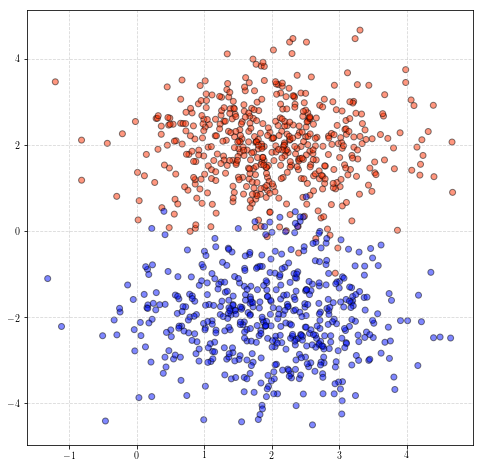

In [224]:
# Generate some data
N = 500
np.random.seed(10)

X_train1 = np.random.randn(N, 2) + np.array([2, 2])
X_train2 = np.random.randn(N, 2) + np.array([2, -2])
X_train = np.vstack([X_train1, X_train2])
y_train = np.concatenate([np.ones(N), np.zeros(N)]).astype(np.int32)

X_val1 = np.random.randn(N, 2) + np.array([2, 2])
X_val2 = np.random.randn(N, 2) + np.array([2, -3])
X_val = np.vstack([X_val1, X_val2])
y_val  = np.concatenate([np.ones(N), np.zeros(N)]).astype(np.int32)

plt.figure(figsize=(8, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='jet', vmin=-0.2, vmax=1.2, edgecolors='k', alpha=0.5)
plt.grid(linestyle='--', alpha=0.5)

data = {'X_train': X_train, 'y_train': y_train,
        'X_val':   X_val,  'y_val': y_val}

Define a **logistic regression** for debugging. 

<a id='toy1'></a>
## 2.1 Network 1<sup>[toc](#toc)</sup>

**Initially batch size set to 1000 to ensure that every step lowers the loss.**

Dense(2->2)->SoftMax->[MulticlassLogLoss]
OrderedDict([('Dense0:W', array([[ 1.14858562, -0.43257711],
       [-0.37347383, -0.75870339]])), ('Dense0:b', array([ 0.,  0.]))])
OrderedDict([('Dense0:W', array([[ 0.,  0.],
       [ 0.,  0.]])), ('Dense0:b', array([ 0.,  0.]))])
num of epochs = 100
num of iterations = 100
iterations per epoch = 1
(Epoch 10/100) train acc: 0.97; val acc: 0.96, train loss: 0.2133; val loss: 0.1715
(Epoch 20/100) train acc: 0.97; val acc: 0.98, train loss: 0.1397; val loss: 0.09345
(Epoch 30/100) train acc: 0.98; val acc: 0.99, train loss: 0.1168; val loss: 0.07296
(Epoch 40/100) train acc: 0.98; val acc: 0.99, train loss: 0.1043; val loss: 0.06322
(Epoch 50/100) train acc: 0.98; val acc: 0.99, train loss: 0.09648; val loss: 0.05742
(Epoch 60/100) train acc: 0.98; val acc: 0.99, train loss: 0.09108; val loss: 0.0543
(Epoch 70/100) train acc: 0.98; val acc: 0.99, train loss: 0.08692; val loss: 0.05152
(Epoch 80/100) train acc: 0.98; val acc: 0.99, train loss: 

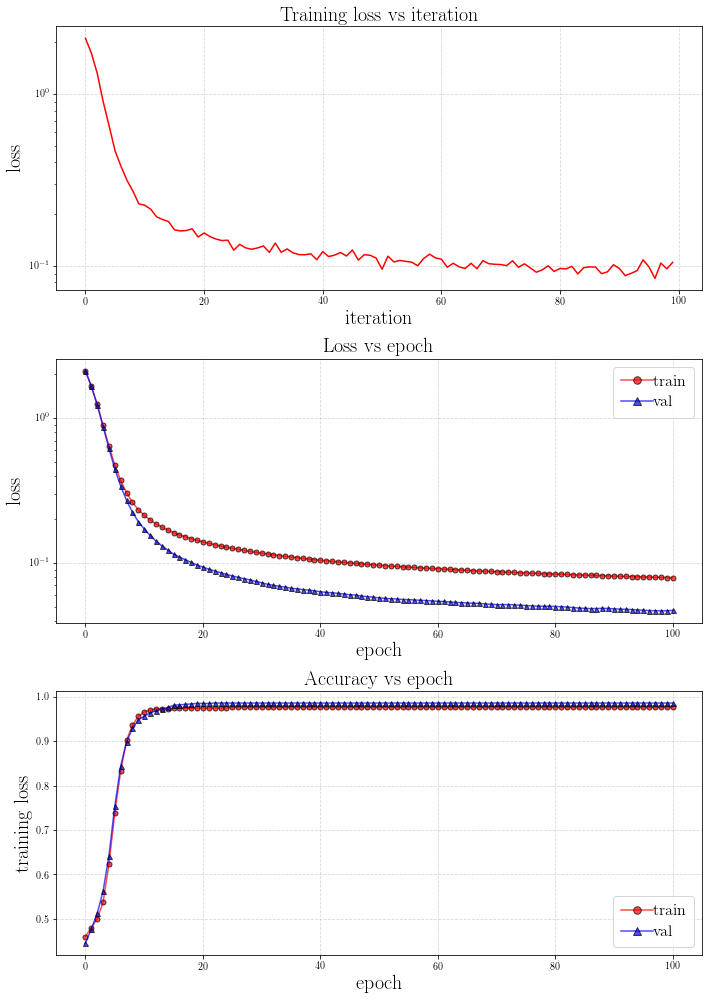

Final val loss:    0.0469583469202
Final val accuracy: 0.986


In [225]:
net = Sequential([Dense(2, W_reg=L2regularizer(0.01)), SoftMax()])
criterion = MulticlassLogLoss()
model = Model(net, criterion)

update_rule = 'sgd'
learning_rate = 0.1
learning_rate_decay = 1.0
momentum = 0.1
optim_config = {'update_rule':   update_rule, 
                'learning_rate': learning_rate,
                'learning_rate_decay': learning_rate_decay,
                'momentum': momentum}
solver = Solver(model=model, data=data, optim_config=optim_config, verbose=True,
                n_epochs=100, batch_size=1000, print_every_epoch=10, seed=0)
print(model.get_params())
print(model.get_grad_params())
model = solver.train()
plot_solver_history(solver.history);
print('Final val loss:   ', solver.history['val_loss_history'][-1])
print('Final val accuracy:', solver.history['val_acc_history'][-1])

#### Stochastic version

Dense(2->2)->SoftMax->[MulticlassLogLoss]
num of epochs = 100
num of iterations = 1000
iterations per epoch = 10


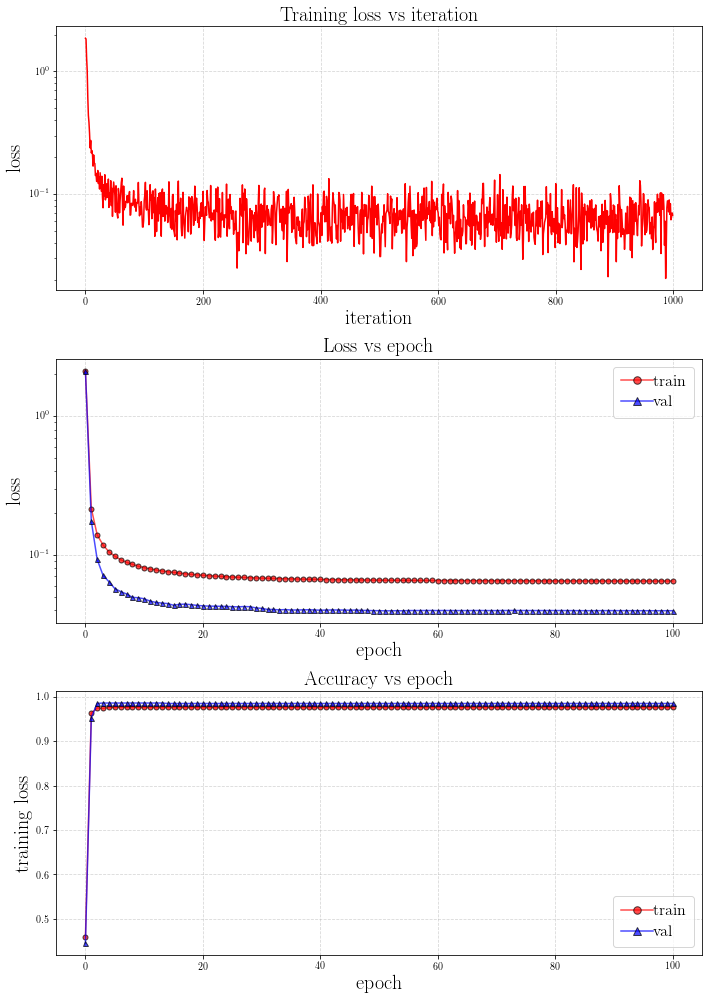

Final val loss:    0.0395988817048
Final val accuracy: 0.985


In [226]:
l2_reg = 0.00
dense = Dense(2, W_reg=L2regularizer(l2_reg))
softmax = SoftMax()
layers = [dense, softmax]
net = Sequential(layers)
criterion = MulticlassLogLoss()
model = Model(net, criterion)

update_rule = 'sgd'
learning_rate = 0.1
learning_rate_decay = 0.95
momentum = 0.9
optim_config = {'update_rule':   update_rule, 
                'learning_rate': learning_rate,
                'learning_rate_decay': learning_rate_decay,
                'momentum': momentum}
solver = Solver(model=model, data=data, model_config={'grad_clip': np.inf}, optim_config=optim_config, verbose=True,
                n_epochs=100, batch_size=100, seed=0)
model = solver.train()
plot_solver_history(solver.history);
print('Final val loss:   ', solver.history['val_loss_history'][-1])
print('Final val accuracy:', solver.history['val_acc_history'][-1])

<a id='toy_example_net2'></a>
## 2.2 Network 2 [[toc]](#toc)

Dense(2->4)->ReLU->Dense(4->2)->SoftMax->[MulticlassLogLoss]
num of epochs = 100
num of iterations = 1000
iterations per epoch = 10


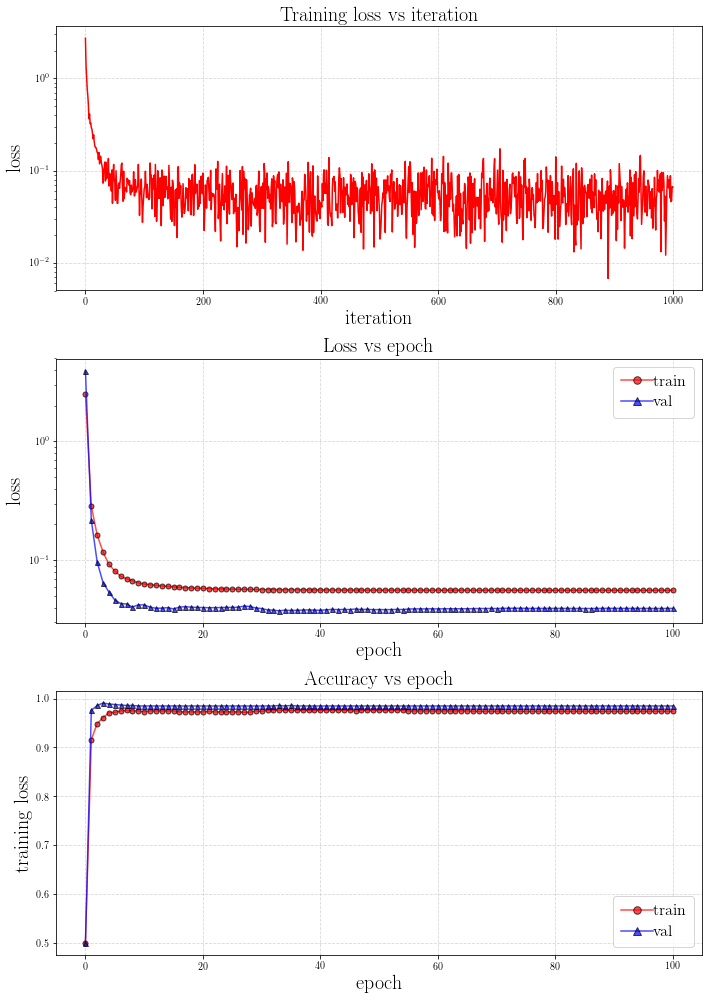

Final val loss:    0.0393622546418
Final val accuracy: 0.985


In [227]:
net = Sequential([Dense(4), ReLU(), Dense(2), SoftMax()])
criterion = MulticlassLogLoss()
model = Model(net, criterion)

update_rule = 'sgd'
learning_rate = 0.1
learning_rate_decay = 0.95
momentum = 0.1
optim_config = {'update_rule':   update_rule, 
                'learning_rate': learning_rate,
                'learning_rate_decay': learning_rate_decay,
                'momentum': momentum}
solver = Solver(model=model, data=data, model_config={'grad_clip': np.inf}, optim_config=optim_config, verbose=True,
                n_epochs=100, batch_size=100, print_every_epoch=None, print_every_iter=None, seed=0)
model = solver.train()
plot_solver_history(solver.history);
print('Final val loss:   ', solver.history['val_loss_history'][-1])
print('Final val accuracy:', solver.history['val_acc_history'][-1])

<a id='digits'></a>
# 3. Digits classification [[toc]](#toc)

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures.

(70000, 784) (70000,)
(63000, 784) (63000,)
(7000, 784) (7000,)


/home/alexander/anaconda3/envs/tensorflow/lib/python3.4/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


<a id='digits_test_run'></a>
## 3.1 Test run [[toc]](#toc)

In [267]:
net = Sequential()
net.add(Dense(10))
net.add(SoftMax())
criterion = MulticlassLogLoss()
model = Model(net, criterion)

optim_config = {'update_rule':        'adam', 
                'learning_rate':       0.001,
                'learning_rate_decay': 0.995,
                'momentum':            0.1}
solver = Solver(model=model, data=data, optim_config=optim_config, verbose=False,
                n_epochs=100, batch_size=100, print_every_epoch=5)
print(model)
model = solver.train()
plot_solver_history(solver.history);
print('Final val loss:   ',  solver.history['val_loss_history'][-1])
print('Final val accuracy:', solver.history['val_acc_history'][-1])

Dense(784->10)->SoftMax->[MulticlassLogLoss]
(Epoch 5/100) train acc: 0.92; val acc: 0.92, train loss: 0.2722; val loss: 0.2864


KeyboardInterrupt: 

<a id='comp_architectures'></a>
## X.X Comparison of architectures [[toc]](#toc)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` between `Dense` layer and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

In [ ]:
def get_MNIST_data(train_size=69000, val_size=1000,  
                   substract_mean=False, normalize_by=None, 
                   mnist_dir='datasets/MNIST', random_state=1, verbose=False):
    filename = mnist_dir + 'mnist.npz'
    if os.path.exists(filename):
        with np.load(filename, 'r') as data:
            X = data['X']
            y = data['y']
    else:
        from sklearn.datasets import fetch_mldata
        mnist = fetch_mldata("mnist-original")
        X, y = mnist.data, mnist.target
        np.savez(filename, X=X, y=y)
        
    # splitting
    assert train_size + val_size <= X.shape[0]
    from sklearn.utils import resample
    X, y = resample(X, y, n_samples=train_size + val_size, replace=False, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=train_size, random_state=random_state + 1)
    # centering
    if substract_mean:
        mean_image = X_train.mean(axis=0, keepdims=True)
        X_train -= mean_image
        X_val -= mean_image
    # normalizing  
    if normalize_by is not None:
        X_train /= normalize_by
        X_val /= normalize_by
    if verbose:
        print('X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
        print('X_val.shape = {}, y_val.shape = {}'.format(X_val.shape, y_val.shape))
    return {'X_train': X_train, 'y_train': y_train,
            'X_val': X_val, 'y_val': y_val}

In [40]:
DATASET = 'cifar'
if DATASET == 'cifar':
    cdata = get_CIFAR10_data(image_data_format='channels_first', cifar10_dir=CIFAR10_DIR, ordered=False,
                             ravel=True, substract_mean=True, random_state=1, normalize_by=255.0, verbose=True)
elif DATASET == 'mnist':
    data = get_mnist_data(train_size=69000, val_size=1000, substract_mean=True, normalize_by=255.0, 
                          verbose=True, random_state=1, mnist_dir=MNIST_DIR)
else: 
    assert False, 'Unknown dataset'

/home/alexander/anaconda3/envs/tensorflow/lib/python3.4/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Training data shape:  (49000, 3072)
Training labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


<a id='test_net_gen'></a>
### 3.2.1 Generator of test network<sup>[toc](#toc)</sup>

In [121]:
ACTIVATIONS = {
    "Tanh": Tanh,
    "ReLU": ReLU,
    "LeakyReLU": LeakyReLU,
    "ELU": ELU,
    "SoftPlus": SoftPlus 
}

def create_model(activation, hidden_sizes, use_dropout=False, use_batchnorm=False, **params):
    net = Sequential()
    for hidden_size in hidden_sizes[:-1]:
        net.add(Dense(hidden_size))
        net.add(ACTIVATIONS[activation]())
        if use_batchnorm:
            net.add(BatchNormalization())
        if use_dropout:
            net.add(Dropout(params['dropout_prob']))
    net.add(Dense(hidden_sizes[-1]))
    net.add(SoftMax())
    criterion = MulticlassLogLoss()
    return Model(net, criterion)
    
model = create_model('Tanh', [100, 10], False, True, dropout_prob=0.1)
model = model.compile(input_shape=data['X_train'].shape, dtype=np.float64, seed=11)
print(model)

NameError: name 'data' is not defined

<a id='comparison'></a>
### 3.2.2 Comparison<sup>[toc](#toc)</sup>

In [94]:
expit(-1000)

0.0

In [42]:
results_filename = 'comparison_architecture_{}.pkl'.format(DATASET)
if os.path.isfile(results_filename):
    RESULTS = pkl.load(open(results_filename, 'rb'))
    print('Already calculated')
else:
    RESULTS = {}

In [125]:
optim_config = {'update_rule':        'adam', 
                'momentum':            0.5,
                'learning_rate_decay': 0.975}
for activation, use_batchnorm in product(['Tanh', 'ReLU', 'LeakyReLU', 'ELU', 'SoftPlus'], [False, True]):
    print('activation = {}, use_batchnorm = {}'.format(activation, use_batchnorm))
    if (activation, use_batchnorm) in RESULTS:
        #print('Already calculated for {}'.format(activation, use_batchnorm))
        continue
    model = create_model(activation, [100, 100, 10], use_batchnorm=use_batchnorm)
    solver = Solver(model, cifar_data, model_config={'debug': True}, optim_config=optim_config, n_epochs=10, 
                    batch_size=100, print_every_epoch=1, verbose=False, seed=11)
    print(model)
    solver.train()
    RESULTS[(activation, use_batchnorm)] = solver.history
    pkl.dump(RESULTS, open(results_filename, 'wb'))
    print('\n\n')

activation = Tanh, use_batchnorm = False
activation = Tanh, use_batchnorm = True
activation = ReLU, use_batchnorm = False
activation = ReLU, use_batchnorm = True
activation = LeakyReLU, use_batchnorm = False
activation = LeakyReLU, use_batchnorm = True
activation = ELU, use_batchnorm = False
activation = ELU, use_batchnorm = True
activation = SoftPlus, use_batchnorm = False
activation = SoftPlus, use_batchnorm = True
Dense(3072->100)->SoftPlus->BatchNormalization->Dense(100->100)->SoftPlus->BatchNormalization->Dense(100->10)->SoftMax->[MulticlassLogLoss]


KeyboardInterrupt: 

KeyError: ('SoftPlus', False)

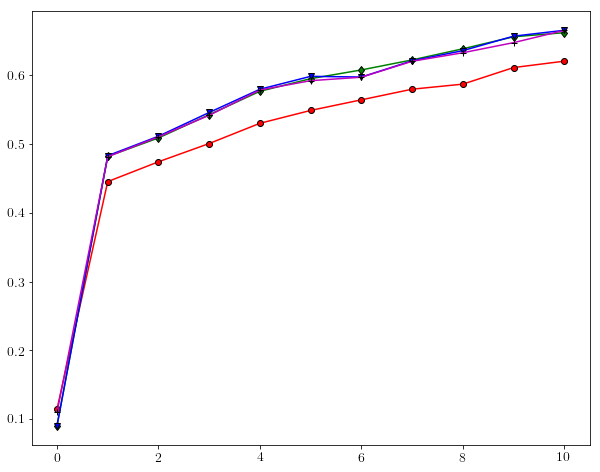

In [123]:
plt.figure(figsize=(10, 8))
results = pkl.load(open(results_filename, 'rb'))
markers = ['o', 'd', 'v', '+', 'p', '*', 's', '^', 'h', 'x']
colors = ['r', 'g', 'b', 'm', 'y', 'k']
for i, (use_batchnorm, activation) in enumerate(product(
        [False, True], 
        ['Tanh', 'ReLU', 'LeakyReLU', 'ELU', 'SoftPlus'])):
    if use_batchnorm: label = activation + ' + batchnorm'
    else: label = activation
    plt.plot(results[(activation, use_batchnorm)]['train_acc_history'], markeredgecolor='k',
             label=label, marker=markers[i], color=colors[i % len(colors)], ms=6)
plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')

plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim([1e-1, 1]);
plt.grid(which='both', alpha=0.5, linestyle='--')

#### Write your personal opinion on the activation functions, think about computation times too. Does `BatchMeanSubtraction` help?

#### Answer

According to the obtained results, the best activations fucntions (at least for the considered task) are ReLU and LeakyReLU. They results in much the lower loss in comparison with the other activations. However, Tanh, ELU and SoftPlus are also not so bad: after 100 iteration they converge to the loss having almost the same accuracy (though the loss itself is almost 2 magnitutes higher than that of the ReLU and LeakyReLU activations).  

As for the **mean substraction**, generally it results learning quality degradation. In case of ReLU, LeakyReLU and ELU, the usage of mean substraction even results in the model divergance. It is due to the too high values in exponents inside the model. The destractive behavior of the mean substraction seems to be a result of the nature of the ReLU, LeakyReLU and ELU activations. Every time the mean substraction is used, it basically switchses off all layer neurons with output values lower than 0. In case of uniform neuron values distribution, approximately the half the output neuron values falls lower than 0 and do not activates. The gradient may show, that some of these neurons should be activated, and the model tries to increase their values. But every time some neurons gets activated, some of them gets deactivated and the process of increasing neuron values continues. Eventually, it can result in the overflow and the model divergance.

The situation about mean substraction can be significantly improved by introducing scaling $\gamma$ and shift $\beta$ parameters.

<a id='final_run'></a>
## 3.3 Final run [[toc]](#toc)
**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. 

In [ ]:
net = Sequential()
net.add(Linear(n_features, 200))
net.add(ReLU())
net.add(Dropout(0.1))
net.add(Linear(200, 200))
net.add(ELU())
net.add(Dropout(0.1))
net.add(Linear(200, n_classes))
net.add(SoftMax())

print('NETWORK ARCHITECTURE:')
print(net)
 
lr = 0.01
momentum = 0.9
optimizer = SgdOptimizer(lr, momentum)
criterion = ClassNLLCriterion()
trainer = ModelTrainer(net, criterion, optimizer)

nb_epochs = 100
batch_size = 100
verbose = 0
for nb_epoch in range(nb_epochs):
    loss = trainer.train(X_train, Y_train, nb_epoch=1, batch_size=batch_size, verbose=verbose)[-1]
    y_pred = trainer.predict(X_test)
    y_true = np.argmax(Y_test, axis=1)
    accuracy = accuracy_score(y_true, y_pred)
    print('epoch = {}: loss = {}, accuracy = {}'.format(nb_epoch, loss, accuracy))

#### Your answer goes here.
The accuracy is around 0.981.

<a id='cifar'></a>
# 4. CIFAR-10 [[toc]](#toc)

<a id='cifar_load'></a>
## 4.1 Loading data [[toc]](#toc)

In [228]:
%%time
gc.collect()

data = get_CIFAR10_data(image_data_format='channels_first', cifar10_dir=CIFAR10_DIR, ordered=False,
                        substract_mean=True, random_state=1, normalize_by=255.0)

X_train = data['X_train']; y_train = data['y_train']
X_val   = data['X_val'];   y_val   = data['y_val']
X_test  = data['X_test'];  y_test  = data['y_test']
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ',   X_test.shape)
print('Test labels shape: ', y_test.shape)

/home/alexander/anaconda3/envs/tensorflow/lib/python3.4/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Training data shape:  (49000, 3, 32, 32)
Training labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3, 32, 32)
Test labels shape:  (1000,)
CPU times: user 2.23 s, sys: 1.5 s, total: 3.73 s
Wall time: 4.03 s


<a id='fcn_checks'></a>
## X.X Checks [[toc]](#toc)

<a id='check_overfit'></a>
### X.X.1 Overfitting small data [[toc]](#toc)

As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

In [255]:
# TODO: Use a three-layer Net to overfit 50 training examples.
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train].reshape((num_train, -1)),
  'y_train': data['y_train'][:num_train],
  'X_val':   data['X_val'].reshape((data['X_val'].shape[0], -1)),
  'y_val':   data['y_val'],
}

model = Model(Sequential([Dense(100), ReLU(), Dense(100), ReLU(), Dense(10), SoftMax()]), MulticlassLogLoss())
optim_config = {'update_rule': 'sgd', 'learning_rate': 0.1}
solver = Solver(model, small_data, optim_config=optim_config, 
                n_epochs=20, batch_size=25, seed=0,
                verbose=False, print_every_epoch=1)
print(model)
model = solver.train()

Dense(3072->100)->ReLU->Dense(100->100)->ReLU->Dense(100->10)->SoftMax->[MulticlassLogLoss]
(Epoch 1/20) train acc: 0.44; val acc: 0.15, train loss: 2.162; val loss: 2.281
(Epoch 2/20) train acc: 0.66; val acc: 0.18, train loss: 2.038; val loss: 2.26
(Epoch 3/20) train acc: 0.62; val acc: 0.19, train loss: 1.91; val loss: 2.248
(Epoch 4/20) train acc: 0.66; val acc: 0.21, train loss: 1.763; val loss: 2.219
(Epoch 5/20) train acc: 0.72; val acc: 0.22, train loss: 1.631; val loss: 2.188
(Epoch 6/20) train acc: 0.72; val acc: 0.23, train loss: 1.5; val loss: 2.164
(Epoch 7/20) train acc: 0.74; val acc: 0.21, train loss: 1.375; val loss: 2.152
(Epoch 8/20) train acc: 0.72; val acc: 0.22, train loss: 1.253; val loss: 2.159
(Epoch 9/20) train acc: 0.74; val acc: 0.23, train loss: 1.159; val loss: 2.149
(Epoch 10/20) train acc: 0.78; val acc: 0.22, train loss: 1.045; val loss: 2.142
(Epoch 11/20) train acc: 0.8; val acc: 0.23, train loss: 0.9588; val loss: 2.149
(Epoch 12/20) train acc: 0.82;

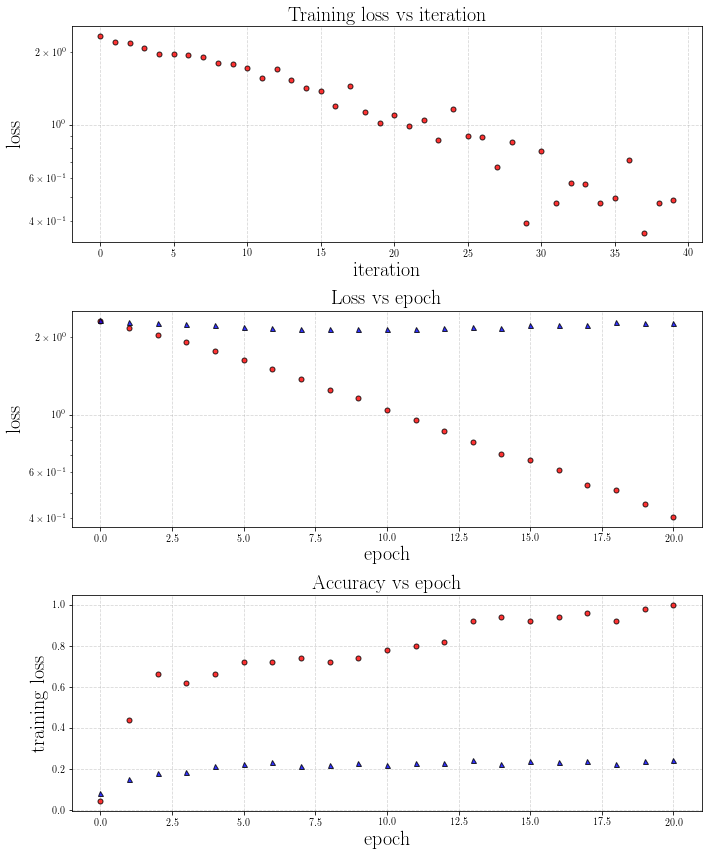

In [256]:
f, axarr = plt.subplots(3, 1, figsize=(10, 12))

ax = axarr[0]
ax.plot(solver.loss_history, 'o', color='r', markeredgecolor='k', alpha=0.8, ms=5)
ax.set_yscale('log')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.set_title('Training loss vs iteration')
ax.grid(linestyle='--', alpha=0.5)

ax = axarr[1]
ax.plot(solver.train_loss_history, 'o', color='r', markeredgecolor='k', alpha=0.8, ms=5)
ax.plot(solver.val_loss_history, '^', color='b', markeredgecolor='k', alpha=0.8, ms=5)
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss vs epoch')
ax.grid(linestyle='--', alpha=0.5)

ax = axarr[2]
ax.plot(solver.train_acc_history, 'o', color='r', markeredgecolor='k', alpha=0.8, ms=5)
ax.plot(solver.val_acc_history, '^', color='b', markeredgecolor='k', alpha=0.8, ms=5)
ax.set_xlabel('epoch')
ax.set_ylabel('training loss')
ax.set_title('Accuracy vs epoch')
ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

In [263]:
# TODO: Use a five-layer Net to overfit 50 training examples.
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train].reshape((num_train, -1)),
  'y_train': data['y_train'][:num_train],
  'X_val':   data['X_val'].reshape((data['X_val'].shape[0], -1)),
  'y_val':   data['y_val'],
}

model = Model(Sequential([Dense(100), ReLU(), 
                          Dense(100), ReLU(),
                          Dense(100), ReLU(),
                          Dense(100), ReLU(),
                          Dense(10),  SoftMax()]), MulticlassLogLoss())
optim_config = {'update_rule': 'sgd', 'learning_rate': 0.3, 'learning_rate_decay': 0.95}
solver = Solver(model, small_data, optim_config=optim_config, 
                n_epochs=20, batch_size=25, seed=0,
                verbose=False, print_every_epoch=1)
print(model)
model = solver.train()

Dense(3072->100)->ReLU->Dense(100->100)->ReLU->Dense(100->100)->ReLU->Dense(100->100)->ReLU->Dense(100->10)->SoftMax->[MulticlassLogLoss]
(Epoch 1/20) train acc: 0.4; val acc: 0.15, train loss: 2.236; val loss: 2.297
(Epoch 2/20) train acc: 0.44; val acc: 0.12, train loss: 2.17; val loss: 2.295
(Epoch 3/20) train acc: 0.52; val acc: 0.12, train loss: 2.075; val loss: 2.295
(Epoch 4/20) train acc: 0.38; val acc: 0.12, train loss: 1.916; val loss: 2.304
(Epoch 5/20) train acc: 0.54; val acc: 0.19, train loss: 1.783; val loss: 2.284
(Epoch 6/20) train acc: 0.46; val acc: 0.17, train loss: 1.643; val loss: 2.338
(Epoch 7/20) train acc: 0.52; val acc: 0.18, train loss: 1.623; val loss: 2.35
(Epoch 8/20) train acc: 0.62; val acc: 0.2, train loss: 1.286; val loss: 2.364
(Epoch 9/20) train acc: 0.68; val acc: 0.18, train loss: 1.295; val loss: 2.373
(Epoch 10/20) train acc: 0.6; val acc: 0.2, train loss: 1.175; val loss: 2.363
(Epoch 11/20) train acc: 0.8; val acc: 0.19, train loss: 0.865; val

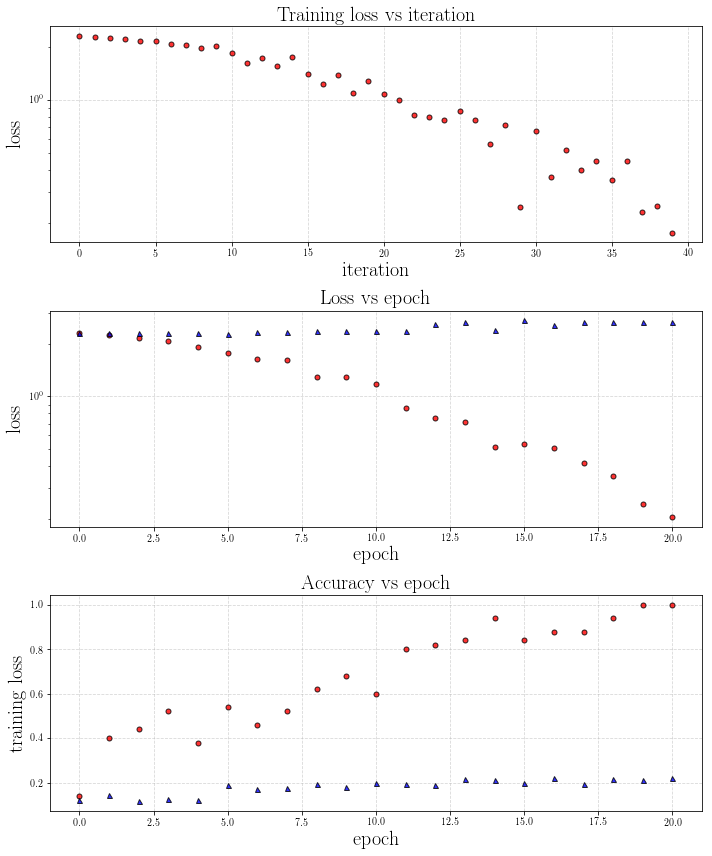

In [264]:
f, axarr = plt.subplots(3, 1, figsize=(10, 12))

ax = axarr[0]
ax.plot(solver.loss_history, 'o', color='r', markeredgecolor='k', alpha=0.8, ms=5)
ax.set_yscale('log')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.set_title('Training loss vs iteration')
ax.grid(linestyle='--', alpha=0.5)

ax = axarr[1]
ax.plot(solver.train_loss_history, 'o', color='r', markeredgecolor='k', alpha=0.8, ms=5)
ax.plot(solver.val_loss_history, '^', color='b', markeredgecolor='k', alpha=0.8, ms=5)
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss vs epoch')
ax.grid(linestyle='--', alpha=0.5)

ax = axarr[2]
ax.plot(solver.train_acc_history, 'o', color='r', markeredgecolor='k', alpha=0.8, ms=5)
ax.plot(solver.val_acc_history, '^', color='b', markeredgecolor='k', alpha=0.8, ms=5)
ax.set_xlabel('epoch')
ax.set_ylabel('training loss')
ax.set_title('Accuracy vs epoch')
ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### Inline question: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?

#### Answer:
[FILL THIS IN]

<a id='comp_updates'></a>
## X.X Comparison of update rules [[toc]](#toc)

In [235]:
recalculate = True # If true, all update rules are run again
calculated_ = False
results_filename = 'update_rules_comparison.pkl'
if (not recalculate) & os.path.isfile(filename):
    RESULTS = pkl.load(open(results_filename, 'rb'))
    calculated_ = True
    print('Already calculated')
else:
    RESULTS = {}

In [236]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train].reshape((num_train, -1)),
  'y_train': data['y_train'][:num_train],
  'X_val':   data['X_val'].reshape((data['X_val'].shape[0], -1)),
  'y_val':   data['y_val'],
}

optim_configs = {'sgd':          {'learning_rate': 1e-2},
                 'sgd_momentum': {'learning_rate': 1e-2, 'momentum': 0.9},
                 'rmsprop':      {'learning_rate': 1e-3, 'decay_rate': 0.99},
                 'adam':         {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2': 0.999}}
for update_rule, config in optim_configs.items():
    config['learning_rate_decay'] = 1.0
    config['update_rule'] = update_rule

#model_config = {'debug': True}
model_config = {}
    
if (not calculated_) or recalculate:
    print('STARTING CALCULATIONS:')
    for update_rule in ['sgd', 'sgd_momentum', 'rmsprop', 'adam']:
        print('\trunning with: ', update_rule)
        
        net = Sequential([Dense(100), ReLU(), 
                          Dense(100), ReLU(),
                          Dense(100), ReLU(),
                          Dense(100), ReLU(),
                          Dense(10),  SoftMax()])
        criterion = MulticlassLogLoss()
        model = Model(net, criterion)
        
        solver = Solver(model, small_data, model_config=model_config, optim_config=optim_configs[update_rule],
                        n_epochs=50, batch_size=100, print_every_epoch=1, seed=123)
        print(model)
        solver.train()
        RESULTS[update_rule] = solver.history
        print()
        pkl.dump(RESULTS, open(results_filename, 'wb'))
else:
    print('Already calculated')

STARTING CALCULATIONS:
	running with:  sgd
Dense(3072->100)->ReLU->Dense(100->100)->ReLU->Dense(100->100)->ReLU->Dense(100->100)->ReLU->Dense(100->10)->SoftMax->[MulticlassLogLoss]
(Epoch 1/50) train acc: 0.15; val acc: 0.15, train loss: 2.293; val loss: 2.294
(Epoch 2/50) train acc: 0.17; val acc: 0.16, train loss: 2.282; val loss: 2.285
(Epoch 3/50) train acc: 0.18; val acc: 0.17, train loss: 2.27; val loss: 2.274
(Epoch 4/50) train acc: 0.21; val acc: 0.18, train loss: 2.255; val loss: 2.26
(Epoch 5/50) train acc: 0.23; val acc: 0.2, train loss: 2.238; val loss: 2.244
(Epoch 6/50) train acc: 0.25; val acc: 0.23, train loss: 2.22; val loss: 2.227
(Epoch 7/50) train acc: 0.25; val acc: 0.24, train loss: 2.201; val loss: 2.208
(Epoch 8/50) train acc: 0.26; val acc: 0.23, train loss: 2.181; val loss: 2.19
(Epoch 9/50) train acc: 0.26; val acc: 0.24, train loss: 2.16; val loss: 2.17
(Epoch 10/50) train acc: 0.27; val acc: 0.24, train loss: 2.138; val loss: 2.15
(Epoch 11/50) train acc: 0

(Epoch 48/50) train acc: 0.96; val acc: 0.38, train loss: 0.1407; val loss: 5.113
(Epoch 49/50) train acc: 0.95; val acc: 0.35, train loss: 0.1482; val loss: 4.873
(Epoch 50/50) train acc: 0.98; val acc: 0.38, train loss: 0.06692; val loss: 4.671

	running with:  rmsprop
Dense(3072->100)->ReLU->Dense(100->100)->ReLU->Dense(100->100)->ReLU->Dense(100->100)->ReLU->Dense(100->10)->SoftMax->[MulticlassLogLoss]
(Epoch 1/50) train acc: 0.39; val acc: 0.3, train loss: 1.737; val loss: 1.863
(Epoch 2/50) train acc: 0.45; val acc: 0.34, train loss: 1.582; val loss: 1.866
(Epoch 3/50) train acc: 0.52; val acc: 0.38, train loss: 1.401; val loss: 1.826
(Epoch 4/50) train acc: 0.56; val acc: 0.37, train loss: 1.299; val loss: 1.832
(Epoch 5/50) train acc: 0.59; val acc: 0.36, train loss: 1.207; val loss: 1.896
(Epoch 6/50) train acc: 0.62; val acc: 0.36, train loss: 1.124; val loss: 1.951
(Epoch 7/50) train acc: 0.66; val acc: 0.38, train loss: 0.9955; val loss: 1.973
(Epoch 8/50) train acc: 0.7; v

(Epoch 45/50) train acc: 1.0; val acc: 0.39, train loss: 0.002951; val loss: 5.635
(Epoch 46/50) train acc: 1.0; val acc: 0.39, train loss: 0.001886; val loss: 5.655
(Epoch 47/50) train acc: 1.0; val acc: 0.4, train loss: 0.003939; val loss: 5.802
(Epoch 48/50) train acc: 1.0; val acc: 0.39, train loss: 0.002676; val loss: 5.795
(Epoch 49/50) train acc: 1.0; val acc: 0.39, train loss: 0.001248; val loss: 5.818
(Epoch 50/50) train acc: 1.0; val acc: 0.39, train loss: 0.001074; val loss: 5.867



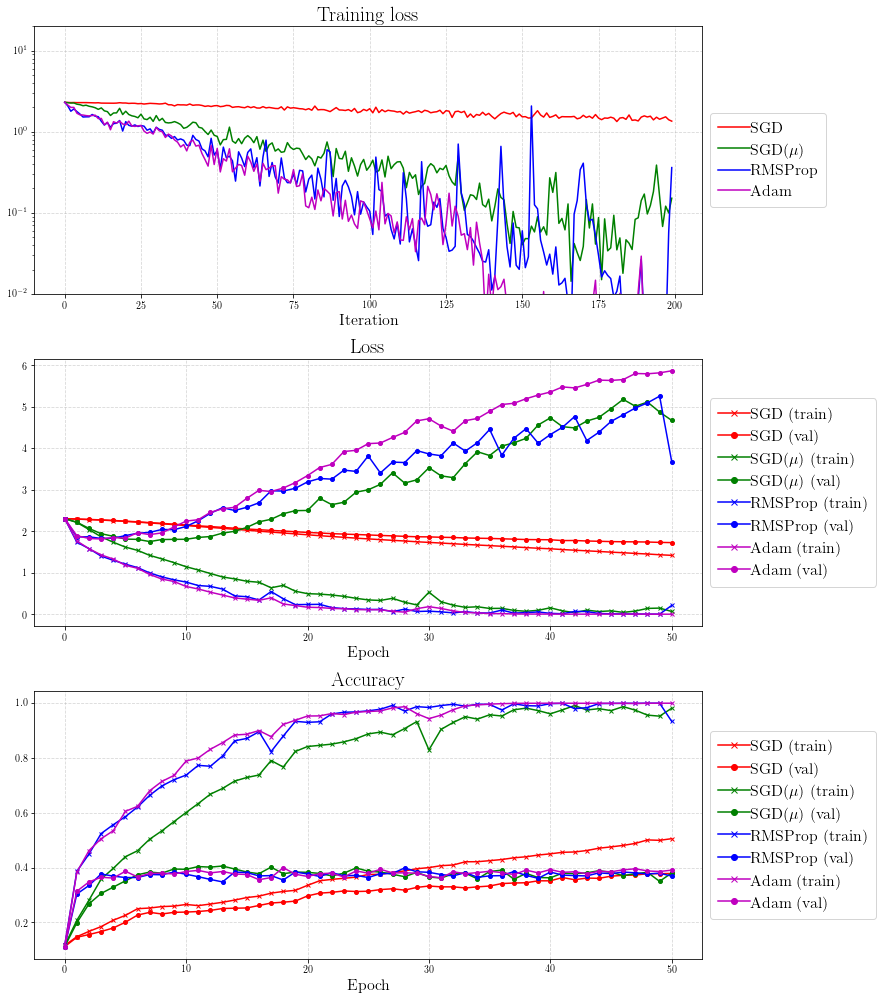

In [237]:
f, axarr = plt.subplots(3, 1, figsize=(10, 14))
titles  = ['Training loss', 'Loss', 'Accuracy']
xlabels = ['Iteration',     'Epoch', 'Epoch']

for i in range(3):
    ax = axarr[i]
    ax.set_title(titles[i], fontsize=20)
    ax.set_xlabel(xlabels[i], fontsize=16)
    
rule_map = {'sgd': r'SGD', 'sgd_momentum': r'SGD($\mu$)', 'rmsprop': 'RMSProp', 'adam': 'Adam'}
markers = {'train': 'x', 'val': 'o'}
colors  = {'sgd': 'r', 'sgd_momentum': 'g', 'rmsprop': 'b', 'adam': 'm'}

for update_rule in ['sgd', 'sgd_momentum', 'rmsprop', 'adam']:
    ax = axarr[0]
    loss_history = RESULTS[update_rule]['loss_history']
    ax.plot(loss_history[::10], '-', color=colors[update_rule], ms=2, label=rule_map[update_rule])
    ax.set_yscale('log')
    ax.set_ylim([1e-2, 20])
    
    ax = axarr[1]
    train_loss_history = RESULTS[update_rule]['train_loss_history']
    ax.plot(train_loss_history, marker=markers['train'], color=colors[update_rule], ms=4, 
            label=rule_map[update_rule] + ' (train)')
    val_loss_history = RESULTS[update_rule]['val_loss_history']
    ax.plot(val_loss_history, marker=markers['val'], color=colors[update_rule], ms=4, 
            label=rule_map[update_rule] + ' (val)')
    
    ax = axarr[2]
    train_acc_history = RESULTS[update_rule]['train_acc_history']
    ax.plot(train_acc_history, marker=markers['train'], color=colors[update_rule], ms=4, 
            label=rule_map[update_rule] + ' (train)')
    val_acc_history = RESULTS[update_rule]['val_acc_history']
    ax.plot(val_acc_history, marker=markers['val'], color=colors[update_rule], ms=4, 
            label=rule_map[update_rule] + ' (val)')

for i in range(3):
    axarr[i].legend(loc='center left', ncol=1, fontsize=16, bbox_to_anchor=(1.0, 0.5))
    axarr[i].grid(linestyle='--', alpha=0.5)
    
plt.tight_layout()
plt.show()

<a id='comp_dropout'></a>
## X.X Dropout [[toc]](#toc)

<a id='comp_dropout_exp'></a>
### X.X.1 Regularization experiment [[toc](#toc)]
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a dropout probability of 0.75. We will then visualize the training and validation accuracies of the two networks over time.

In [ ]:
# Train two identical nets, one with dropout and one without
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.75]
for dropout in dropout_choices:
    model = FullyConnectedNet([500], dropout=dropout)
    print('dropout =', dropout)

    solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every_iter=5)
    solver.train()
    solvers[dropout] = solver

In [ ]:
f, axarr = plt.subplots(3, 1, figsize=(10, 14))
plot_kwargs = {'markeredgecolor': 'k', 'ms': 5, 'alpha': 0.7}
markers = {0: 'o', 0.75: '^'}
colors = {0: 'r', 0.75: 'b'}

for dropout in dropout_choices:
    solver = solvers[dropout]
    
    ax = axarr[0]
    ax.plot(solver.loss_history, color=colors[dropout], label='p = {}'.format(dropout))

    ax = axarr[1]
    ax.plot(solver.train_loss_history, 'o', color=colors[dropout], label='train, p={}'.format(dropout), **plot_kwargs)
    ax.plot(solver.val_loss_history,   '^', color=colors[dropout], label='val, p={}'.format(dropout),   **plot_kwargs)

    ax = axarr[2]
    ax.plot(solver.train_acc_history, 'o', color=colors[dropout], label='train, p={}'.format(dropout), **plot_kwargs)
    ax.plot(solver.val_acc_history,   '^', color=colors[dropout], label='val, p={}'.format(dropout), **plot_kwargs)

ax = axarr[0]   
ax.set_yscale('log')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.set_title('Training loss vs iteration')
ax.grid(linestyle='--', alpha=0.5)
ax.legend(loc='lower left', fontsize=16)

ax = axarr[1]
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss vs epoch')
ax.grid(linestyle='--', alpha=0.5)
ax.legend(loc='lower left', fontsize=16)
    
ax = axarr[2]
ax.set_xlabel('epoch')
ax.set_ylabel('training loss')
ax.set_title('Accuracy vs epoch')
ax.grid(linestyle='--', alpha=0.5)
ax.legend(loc='upper left', fontsize=16)
    
plt.tight_layout()
plt.show()

#### Question
Explain what you see in this experiment. What does it suggest about dropout?
#### Answer

<a id='comp_bn'></a>
## X.X BatchNormalization [[toc]](#toc)

# Autoencoder (optional) 

This part is **OPTIONAL**, you may not do it. It will not be scored, but it is easy and interesting.

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
<img src="autoencoder.png">

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use **MSECriterion** to score the reconstruction. Use **BatchMeanNormalization** between **Linear** and **ReLU**. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [ ]:
# Your code goes here. ################################################

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [ ]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################

# Now build a logistic regression or small classification net
cnet = Sequential()
cnet.add(Linear(30, 2))
cnet.add(SoftMax())

# Learn the weights
# Your code goes here. ################################################

# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
# Your code goes here. ################################################

# And add learned layers ontop.
autoenc.add(cnet[0])
autoenc.add(cnet[1])

# Now optimize whole model
# Your code goes here. ################################################

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [ ]:
# np.clip(prediction,0,1)
#
# Your code goes here. ################################################

<a id='cnn'></a>
# 3. Convolutional Networks  [[toc](#toc)]
So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.